In [1]:
# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import chi2,r_regression
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM,Dropout, BatchNormalization, Dense, Conv1D, MaxPool1D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from keras.optimizer_v2.adam import Adam

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0700.hk')
data.drop("Adj Close",axis=1,inplace=True)
data.tail(15)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2021-12-10,471.000000,474.000000,461.600006,463.399994,15230505
2021-12-13,470.600006,481.000000,466.600006,466.600006,22239831
2021-12-14,460.000000,465.600006,457.399994,459.799988,13651585
2021-12-15,459.600006,464.399994,453.200012,455.799988,13371932
2021-12-16,452.000000,455.200012,448.200012,452.600006,21029463
2021-12-17,447.000000,447.200012,438.000000,438.000000,28284431
2021-12-20,437.399994,439.600006,429.000000,430.000000,20413076
2021-12-21,430.000000,446.799988,429.399994,440.799988,17226545
2021-12-22,450.000000,450.799988,440.399994,443.000000,13839639


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MTM6']=talib.MOM(data['Close'],timeperiod=6)
data['MTM12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Predictions']=data['Close'].shift(-1)
data.dropna(inplace=True)
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', '6day MA', '12day MA', 'RSI',
       '%R5', '%R10', 'MTM6', 'MTM12', 'EMA12', 'EMA26', 'MACD', 'TR', 'OSC6',
       'OSC12', 'Predictions'],
      dtype='object')

In [4]:
def trim_dataset(mat, batch_size):

    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0] % batch_size

    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

def build_timeseries(mat, target):

    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    print("Length of inputs", dim_0)

    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = target[TIME_STEPS+i]

    print("length of time-series - inputs", x.shape)
    print("length of time-series - outputs", y.shape)

    return x, y

train_cols = ['Open', 'High', 'Low', 'Close', 'Volume', '6day MA', '12day MA', 'RSI',
              '%R5', '%R10', 'MTM6', 'MTM12', 'EMA12', 'EMA26', 'MACD', 'TR', 'OSC6',
              'OSC12', 'Predictions']
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 100,
    "lr": 0.00010000,
    "time_steps": 10
}
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))
x = df_train.loc[:,train_cols].values
y = df_train.loc[:,["Predictions"]].values
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
min_max_scaler_y = MinMaxScaler(feature_range=(0,1))
x_train = min_max_scaler.fit_transform(x)
# x_train = x
# y=min_max_scaler_y.fit_transform(y)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
# x_test = df_test.loc[:,train_cols]
y_test = df_test.loc[:,["Predictions"]].values
# y_test=min_max_scaler_y.transform(y_test)
x_t, y_t = build_timeseries(x_train, y)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
# print(x_test.shape)
print("Batch trimmed size", x_t.shape, y_t.shape)

Train--Test size 3444 861
Length of inputs 3434
length of time-series - inputs (3434, 10, 19)
length of time-series - outputs (3434,)
Batch trimmed size (3420, 10, 19) (3420,)


/opt/homebrew/Caskroom/miniforge/base/envs/FYP/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [5]:
x_temp, y_temp = build_timeseries(x_test,y_test)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
x_val,x_unseen=np.split(trim_dataset(x_val, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
y_val, y_unseen = np.split(trim_dataset(y_val, BATCH_SIZE),2)
print(x_unseen.shape)

Length of inputs 851
length of time-series - inputs (851, 10, 19)
length of time-series - outputs (851,)
(210, 10, 19)


In [6]:
model=Sequential()
model.add(Conv1D(32,kernel_size=1,input_shape=(x_t.shape[1],x_t.shape[2])))
model.add(MaxPool1D(1))
model.add(LSTM(64))
model.add(Dense(64))
# model.add(Dense(32))
model.add(Dense(1))
model.compile(
    loss="mean_squared_error",
    optimizer='Adam'
)

Metal device set to: Apple M1 Pro


2022-01-01 01:14:06.866937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-01 01:14:06.867048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            640       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 29,697
Trainable params: 29,697
Non-trainable params: 0
____________________________________________________

In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0)
history=model.fit(x_t,y_t,epochs=300,validation_data=(x_val,y_val),shuffle=False,callbacks=es)

Epoch 1/300


2022-01-01 01:14:07.036345: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-01 01:14:07.476473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-01 01:14:07.608109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  2/107 [..............................] - ETA: 6s - loss: 1.8151  

2022-01-01 01:14:07.717326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - 2s 16ms/step - loss: 11741.7002 - val_loss: 105278.0234
Epoch 2/300
  1/107 [..............................] - ETA: 1s - loss: 21690.5312

2022-01-01 01:14:09.385101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-01 01:14:09.437756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - 1s 12ms/step - loss: 16238.8330 - val_loss: 58725.4219
Epoch 3/300
107/107 [==============================] - 1s 13ms/step - loss: 9780.9756 - val_loss: 42444.0820
Epoch 4/300
107/107 [==============================] - 1s 13ms/step - loss: 6078.3232 - val_loss: 22797.0508
Epoch 5/300
107/107 [==============================] - 1s 13ms/step - loss: 5525.2822 - val_loss: 11285.6299
Epoch 6/300
107/107 [==============================] - 1s 14ms/step - loss: 3146.2566 - val_loss: 6121.1055
Epoch 7/300
107/107 [==============================] - 1s 13ms/step - loss: 1579.4301 - val_loss: 2337.3787
Epoch 8/300
107/107 [==============================] - 1s 13ms/step - loss: 1595.7566 - val_loss: 1094.1165
Epoch 9/300
107/107 [==============================] - 1s 12ms/step - loss: 1748.0950 - val_loss: 800.1641
Epoch 10/300
107/107 [==============================] - 1s 12ms/step - loss: 2230.6123 - val_loss: 779.7904
Epoch 11/300
107/107 [==============

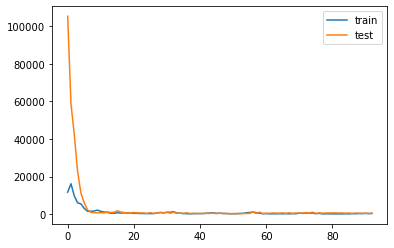

In [9]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [10]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
# y_pred_org = min_max_scaler_y.inverse_transform(y_pred.reshape(-1,1))
y_pred_org = y_pred.reshape(-1,1)
# min_max_scaler.inverse_transform(y_pred)
# y_test_t_org = min_max_scaler_y.inverse_transform(y_test_t.reshape(-1,1))
y_test_t_org =y_test_t.reshape(-1,1)
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org)
print(y_test_t_org)

Error is 115671.75026829398 (420,) (420,)
[405.16525 408.8818  405.54828 408.26956 415.91684 417.71103 421.216
 424.96432 424.13596 423.83276 425.47726 427.158   428.82724 429.50815
 429.66293]
[376.3999939  381.3999939  387.6000061  385.         391.3999939
 395.         395.         406.79998779 409.6000061  408.6000061
 400.6000061  409.3999939  411.6000061  406.3999939  413.        ]
[[405.16525]
 [408.8818 ]
 [405.54828]
 [408.26956]
 [415.91684]
 [417.71103]
 [421.216  ]
 [424.96432]
 [424.13596]
 [423.83276]
 [425.47726]
 [427.158  ]
 [428.82724]
 [429.50815]
 [429.66293]
 [429.56894]
 [429.4541 ]
 [429.36853]
 [429.6383 ]
 [428.8374 ]
 [426.38242]
 [426.08398]
 [427.6821 ]
 [428.99466]
 [429.16696]
 [429.1575 ]
 [428.1598 ]
 [430.41196]
 [428.89255]
 [432.84592]
 [432.9391 ]
 [432.11725]
 [431.59335]
 [429.52066]
 [430.98547]
 [432.7601 ]
 [431.68228]
 [423.63968]
 [418.23047]
 [426.70074]
 [428.5671 ]
 [428.12302]
 [427.06177]
 [432.40414]
 [433.89362]
 [432.28006]
 [429.96127

2022-01-01 01:16:08.815511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-01 01:16:08.858267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


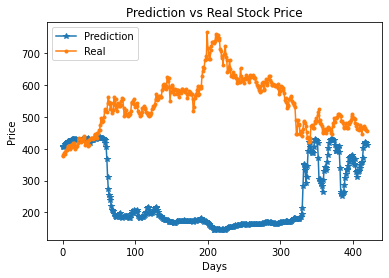

In [11]:
plt.figure()
plt.plot(y_pred_org,marker='*')
plt.plot(y_test_t_org,marker='.')
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')

In [12]:
r2_score(y_test_t_org,y_pred_org)

-15.727942066046058

In [13]:
y_pred_unseen=model.predict(x_unseen)
# y_pred_unseen=min_max_scaler_y.inverse_transform(y_pred_unseen)
# y_unseen=min_max_scaler_y.inverse_transform(y_unseen.reshape(-1,1))

2022-01-01 01:16:09.134304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-01 01:16:09.176875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


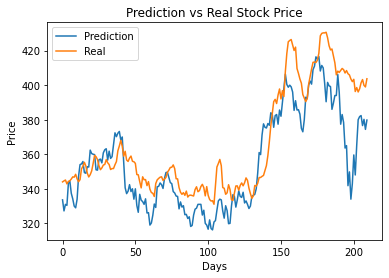

In [14]:
plt.figure()
plt.plot(y_unseen)
plt.plot(y_pred_unseen)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')

In [15]:
r2_score(y_unseen,y_pred_unseen)

0.5391796463206784

In [16]:
mean_squared_error(y_unseen,y_pred_unseen)

339.2926294254405

In [17]:
mean_ab

NameError: name 'mean_ab' is not defined

In [ ]:
# model.save('HSBC-CNN&LSTM')